In [1]:
# 차트를 그리기 위한 라이브러리 설치
!pip install matplotlib seaborn pandas

시각화 준비 완료! 데이터를 불러옵니다...


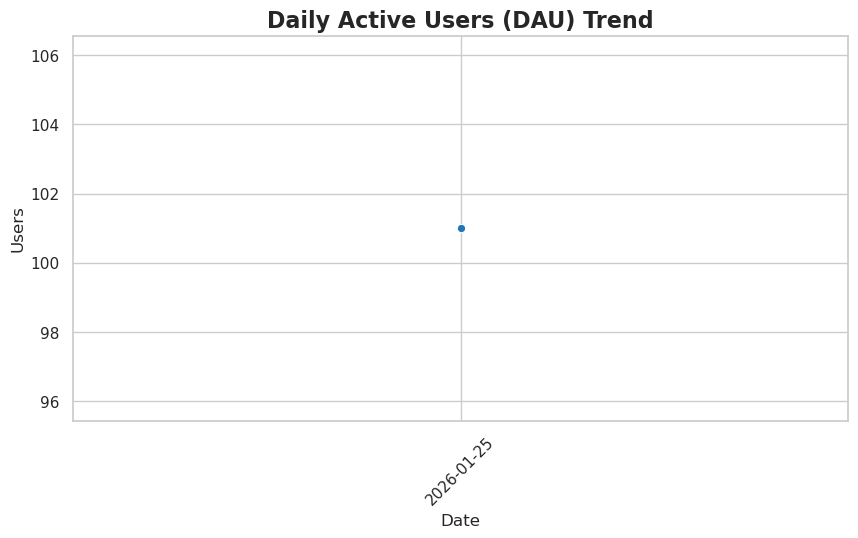

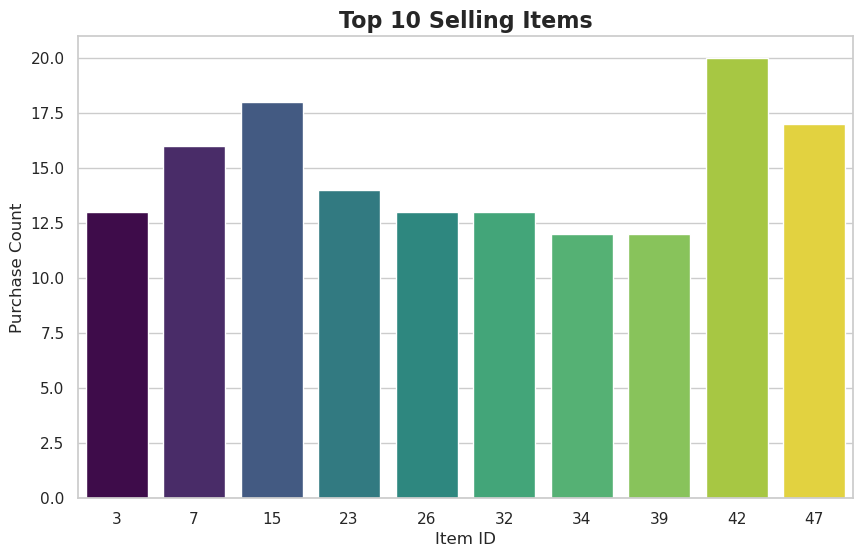

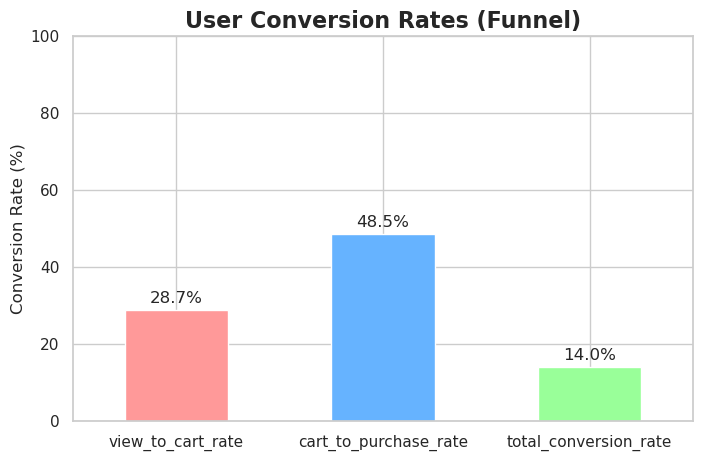

모든 시각화 완료! 프로젝트 대성공!


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession

# --- 설정 (한글 폰트 깨짐 방지 및 스타일) ---
plt.rcParams['font.family'] = 'sans-serif'
sns.set_theme(style="whitegrid")

# Spark 세션 생성 (데이터 읽기용)
spark = SparkSession.builder \
    .appName("TitanLog-Visualization") \
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.3.4,com.amazonaws:aws-java-sdk-bundle:1.12.533") \
    .config("spark.hadoop.fs.s3a.endpoint", "http://titan-minio:9000") \
    .config("spark.hadoop.fs.s3a.access.key", "minioadmin") \
    .config("spark.hadoop.fs.s3a.secret.key", "minioadmin") \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .getOrCreate()

print("시각화 준비 완료! 데이터를 불러옵니다...")

# ==========================================
# 차트 1: 일별 방문자 추이 (Line Chart)
# ==========================================
# 1. Spark로 읽어서 -> Pandas로 변환 (시각화는 Pandas가 편함)
daily_df = spark.read.parquet("s3a://gold/daily_traffic").toPandas().sort_values("date")

plt.figure(figsize=(10, 5))
sns.lineplot(data=daily_df, x="date", y="daily_active_users (DAU)", marker="o", linewidth=2.5, color="#1f77b4")
plt.title("Daily Active Users (DAU) Trend", fontsize=16, fontweight='bold')
plt.xlabel("Date")
plt.ylabel("Users")
plt.xticks(rotation=45)
plt.show()

# ==========================================
# 차트 2: 베스트 셀러 Top 10 (Bar Chart)
# ==========================================
top_items_df = spark.read.parquet("s3a://gold/top_selling_items").toPandas().head(10)

plt.figure(figsize=(10, 6))

# [수정된 부분] x값을 hue에도 똑같이 넣어주고, legend는 껐습니다.
sns.barplot(
    data=top_items_df, 
    x="item_id", 
    y="purchase_count", 
    palette="viridis", 
    hue="item_id",    # 추가됨: 색상을 아이템별로 다르게 하겠다
    legend=False      # 추가됨: 범례는 굳이 필요 없다
)

plt.title("Top 10 Selling Items", fontsize=16, fontweight='bold')
plt.xlabel("Item ID")
plt.ylabel("Purchase Count")
plt.show()

# ==========================================
# 차트 3: 퍼널 전환율 (Funnel Chart)
# ==========================================
funnel_df = spark.read.parquet("s3a://gold/funnel_analysis").toPandas()

# 전체 평균 전환율만 뽑아서 시각화
avg_funnel = funnel_df[["view_to_cart_rate", "cart_to_purchase_rate", "total_conversion_rate"]].mean()

plt.figure(figsize=(8, 5))
avg_funnel.plot(kind='bar', color=['#ff9999', '#66b3ff', '#99ff99'])
plt.title("User Conversion Rates (Funnel)", fontsize=16, fontweight='bold')
plt.ylabel("Conversion Rate (%)")
plt.xticks(rotation=0)
plt.ylim(0, 100) # 0% ~ 100%
for index, value in enumerate(avg_funnel):
    plt.text(index, value + 2, f"{value:.1f}%", ha='center', fontsize=12)
plt.show()

print("모든 시각화 완료! 프로젝트 대성공!")